# Taking a Hankel transform, and generating mock data with `frank`

_This tutorial will show how to take a 1D Fourier transform (a discrete Hankel transform) with `frank`, and how to take this a step further to generate a noisy, mock dataset (visibility distribution) using `frank`._

## Motivation

Taking a 1D Fourier transform (from real to visibility space or vice-versa) is a useful way to visualize the correspondence between a Fourier space visibilitity distribution and a real space brightness profile. Generating a mock dataset and fitting it with `frank` is also helpful to assess the model's intrinsic performance by comparing a `frank` fit to a known result.

## Taking a Hankel transform

Let's demonstrate how to easily take a Hankel transform (a 1D Fourier transform that assumes azimuthal symmetry) using a wrapper function, `frank.utilities.generic_dht`, that interfaces with deeper routines `frank`. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

from frank.geometry import FixedGeometry
from frank.utilities import get_collocation_points, generic_dht, make_mock_data, add_vis_noise, UVDataBinner
from frank.radial_fitters import FrankFitter

%matplotlib inline

First we'll make a simple mock brightness profile, a sum of Gaussians.

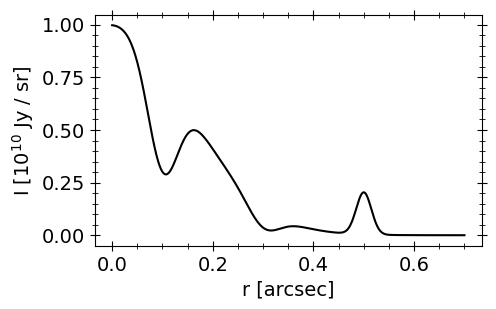

In [2]:
def gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def sigma(fwhm):
    "Provide a Gaussian's FWHM to return its standard deviation"
    return fwhm / (8 * np.sqrt(np.log(2)))

r = np.linspace(0, 0.7, 1000)

# alternatively, define a radial grid at the exact points of a DHT,
# r = get_collocation_points(Rmax=2.0, N=500)

I = gauss(r, 1e10, 0.0, sigma(1.0)) - \
         gauss(r, 5e9, 0.1, sigma(0.2)) - \
         gauss(r, 1e9, 0.3, sigma(0.2)) + \
         gauss(r, 2e9, 0.5, sigma(0.1))

plt.figure(figsize=(5,3))
plt.plot(r, I / 1e10, 'k-')
plt.xlabel('r [arcsec]')
plt.ylabel(r'I $[10^{10}$ Jy / sr]');

Now we'll take the discrete Hankel transform (DHT) of I(r).

In [3]:
# take the forward transform (real --> visibility space)
q_grid, I_transform = generic_dht(r, I)

# take a backward transform (visibility --> real space) of our forward transform.
# this should give us an accurate recovery of the original brightness profile.
r_grid, V_transform = generic_dht(q_grid, I_transform, direction='backward')

If we wanted more control over the DHT, we could amend e.g. our first call to

`q_grid, I_transform = generic_dht(r, I, Rmax=2.0, N=500, direction='forward', grid=None, inc=0.0)`,

in order to pass in: 
- `Rmax` : a radius beyond which the brightness profile is assumed to be zero (it should be reasonably larger than the disk radius)
- `N` : number of terms in the DHT's Fourier-Bessel series (with evens tens of terms it's already quite accurate)
- `grid` : baselines (or for the backward transfer, radii) at which to take the transform
- `inc` : an inclination for the source if we wish to scale the total flux by $\cos(i)$
See the `generic_dht` docstring for more info.

Ok, let's plot everything for comparison.

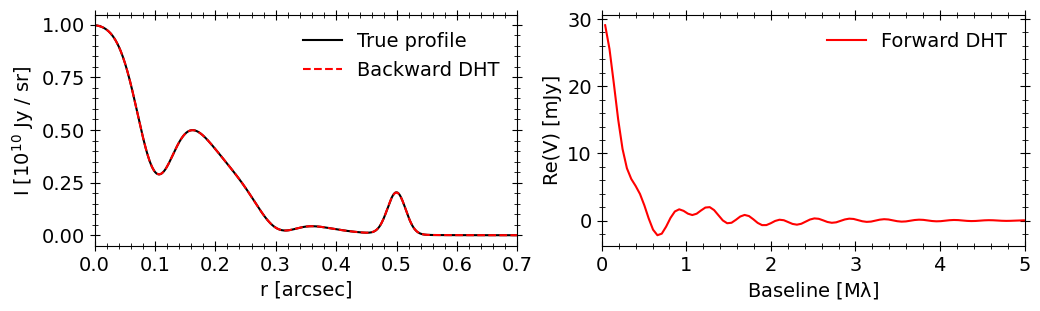

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12,3))

ax = axs[0]
ax.plot(r, I / 1e10, 'k-', label='True profile')
ax.plot(r_grid, V_transform / 1e10, 'r--', label='Backward DHT')
ax.set_xlabel('r [arcsec]')
ax.set_ylabel(r'I $[10^{10}$ Jy / sr]')
ax.set_xlim(0,0.7)
ax.legend()

ax = axs[1]
ax.plot(q_grid / 1e6, I_transform * 1e3, 'r', label='Forward DHT')
ax.set_xlabel(r'Baseline [M$\lambda$]')
ax.set_ylabel('Re(V) [mJy]')
ax.set_xlim(0, 5)
ax.legend();

On the right we have the Fourier transform of our mock brightness profile, and on the left we see that an inverse transform recovers the true brightness profile to high acccuracy. That's it!

## Generating mock data

Now let's use our mock brightness profile to generate a synthetic, noisy visibility distribution, with `frank.utilities.make_mock_data`. We'll sample the mock visibilitiess at the $(u,v)$ coordinates of a real (combined) dataset - the DSHARP observations of AS 209.

In [5]:
# load the DSHARP AS 209 observations
as209_dat = np.load('AS209_continuum.npz')
u, v, vis, weights = [as209_dat[k] for k in ['u', 'v', 'V', 'weights']]

# create a frank geometry object that contains the published geometry values. 
# we'll use the inc and PA to deproject the (u, v) coordinates
geom = FixedGeometry(inc=34.97, PA=85.76, dRA=1.9e-3, dDec=2.5e-3)

In [6]:
# sample the mock profile at the deprojected data baselines, adding Gaussian noise according to the data weights
baselines, V_noisy = make_mock_data(r, I, Rmax=2.0, u=u, v=v, geometry=geom, add_noise=True, weights=weights)

# alternatively we could make mock visibilities without noise,
# baselines, V_noiseless = make_mock_data(r, I, Rmax=2.0, u=u, v=v, geometry=geom, add_noise=False)
# and then add noise afterward, 
# add_vis_noise(V_noiseless, weights)

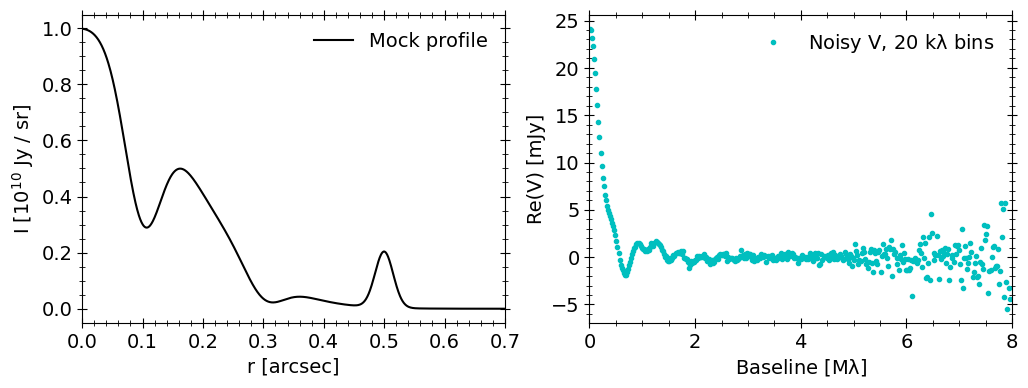

In [14]:
# bin the generated visibilities and plot the result

# bin size [lambda]
bin_width = 20e3

binned_uv = UVDataBinner(baselines, V_noisy, weights=weights, bin_width=bin_width)
baselines_bin = binned_uv.uv
V_noisy_bin = binned_uv.V
    
fig, axs = plt.subplots(1, 2, figsize=(12,4))

ax = axs[0]
ax.plot(r, I / 1e10, 'k-', label='Mock profile')
ax.set_xlabel('r [arcsec]')
ax.set_ylabel(r'I $[10^{10}$ Jy / sr]')
ax.set_xlim(0,0.7)
ax.legend()

ax = axs[1]
ax.plot(baselines_bin / 1e6, V_noisy_bin * 1e3, 'c.', 
        label='Noisy V, {:.0f} k$\lambda$ bins'.format(bin_width/1e3))
ax.set_xlabel(r'Baseline [M$\lambda$]')
ax.set_ylabel('Re(V) [mJy]')
ax.set_xlim(0,8)
ax.legend();

Finally we can fit the noisy mock data with `frank` to see how well we recover the true profile, giving a sense of how accurately we could expect the model to be for a real dataset of similar $(u,v)$ coverage, noise and visibility distribution (or equivalently, underlying brightness profile).

In [8]:
# choose frank hyperparameters
Rmax, N, alpha, weights_smooth = 2.0, 200, 1.01, 1e-4

# initialze the FrankFitter class
FF = FrankFitter(Rmax, N, geometry=geom, alpha=alpha, weights_smooth=weights_smooth)

# fit the data, returning the maximum a posteriori solution object
sol = FF.fit(u, v, V_noisy, weights)

# sample the visibility fit 
vis_fit = sol.predict_deprojected(sol.q).real

Overplot the fit result to see how the model did.

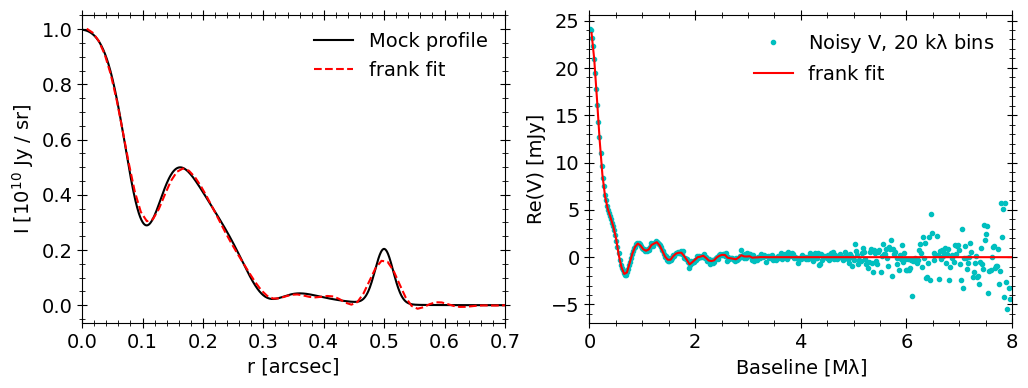

In [15]:
axs[0].plot(sol.r, sol.I / 1e10, 'r--', label='frank fit')
axs[0].legend()

axs[1].plot(sol.q / 1e6, vis_fit * 1e3, 'r', label='frank fit')
axs[1].legend()

fig

It's not a perfect fit, but the data become pretty low signal-to-noise at $\gtrsim 3\ {\rm M}\lambda$, making it difficult to constrain structure in the brightness profile on scales $\lesssim 70$ mas. Hence the low aplitude oscillations in the recovered brightness profile on this scale.